# **Robot vs. Data Scientist**


We optimize an algorithm to correctly identify images with a low error rate using the CIFAR-10 image data set, a widely used dataset for machine learnin
g and image recognition. The data consists of 10 classes of images: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Each of the images are 32x32 color pixels with 6,000 images per class.


In [ ]:
# load libaries
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score

# used to perform intial model
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression

# used to perform optimization models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# used for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10

from numpy.random import seed


## **Define the Question**
- Formulate a binary classification problem .

Can the computer determine whether a user is a human or not by assessing whether it can effectively identify if an image is an object or living thing using the CIFAR-10 data set?

## **Get the Data**
- Describe the steps you used to prepare the data to answer the questions for this classification problem.
- Explain how you split the data for analysis and evaluation, and why you did it that way.
- Did you make any changes to the data or labels?

In [ ]:
# Load data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# Print Dimensions of training and test sets
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(50000, 1)
(50000, 32, 32, 3)
(10000, 1)
(10000, 32, 32, 3)


Based on the label classification on the data, the corresponding labels of object oriented images such as airplane, automobile, ship, or truck were 0, 1, 8, and 9 respectively. The remaining labels corresponded to non-object oriented images (e.g., animals) such as bird, cat, deer, dog, frog, and horse which respresented 2-7 respectively.

Since this is a binary classification problem, we relabel the classifications of object-oriented images as 1, while animals are 0 for our target variable in both datasets.

In [ ]:
# Create vector of the indices that are labeled as object
object_idx = [0,1,8,9]

# Set objects index = 1, ifelse 0 when an animal for both the train and test sets target vectors
y_train_cl = np.where(y_train == object_idx, 1, 0).max(axis=1).reshape(-1,1)
y_test_cl = np.where(y_test == object_idx, 1, 0).max(axis=1).reshape(-1,1)

# check dimensions
print(y_train_cl.shape)
print(y_test_cl.shape)

(50000, 1)
(10000, 1)


In [ ]:
X_train[object_idx].shape

(4, 32, 32, 3)

 ## **Exploratory Data Analysis (EDA)**

- Perform exploratory data analysis (EDA) to first understand the data set and hypothesize what features or methods might be useful (e.g., what features of the images are most similar or different?).
- Summarize your findings from the EDA.

According to the shape of the outputs, it appears that each type of image has 6000 records in the dataset. Per object, there are 5000 images in the training dataset and 1000 images found within the test dataset. We can see this visually below.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


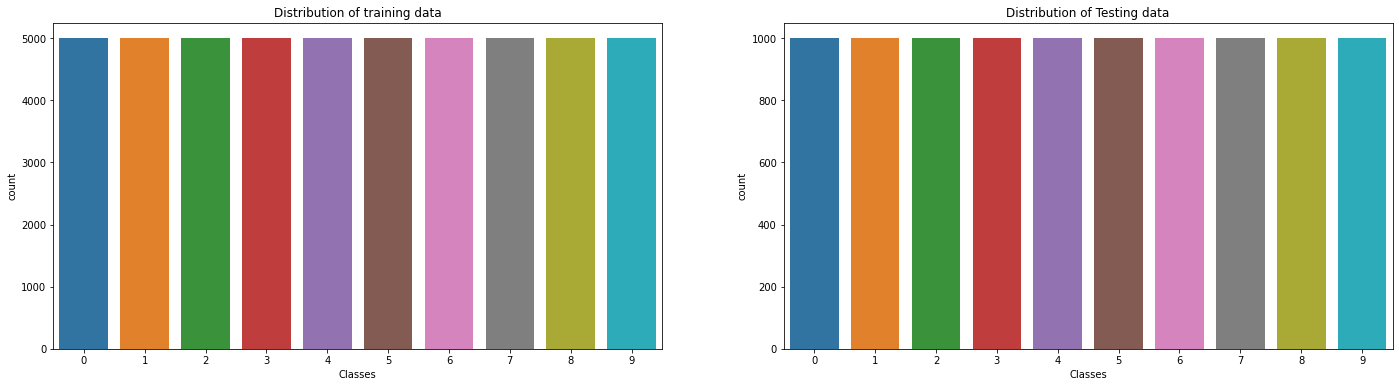

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1,2,figsize=(24,6))
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

Now that we can see the distribution of our data, let's take a look at how an image looks. We can do so by pulling the first image and also looking at whether it is classified as an object or an animal.

In [ ]:
# Create vector of the indices that are labeled as object for the train and test set, respectively
object_idx_train = np.where(y_train == [0,1,8,9])[0]
object_idx_test = np.where(y_test == [0,1,8,9])[0]

# Filters both the train and test sets feature matrices by only object indices
X_train_object = X_train[object_idx_train]
X_test_object = X_test[object_idx_test]

# check dimensions
print(X_train_object.shape)
print(X_test_object.shape)

(20000, 32, 32, 3)
(4000, 32, 32, 3)


In [ ]:
object_idx_train = np.where(y_train == [2,3,4,5,6,7])[0]
object_idx_test = np.where(y_test == [2,3,4,5,6,7])[0]
print(X_train[object_idx_train].shape)
print(X_test[object_idx_test].shape)

(30000, 32, 32, 3)
(6000, 32, 32, 3)


As a result, the object appears to be a truck which checks out as the image is classified as a 0 or an object.

[0]


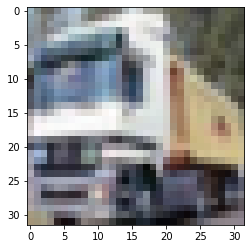

In [ ]:
## checks image data
plt.imshow(X_train_object[0])
print(y_train_cl[0])

Based on the example we used previous, we examine the color palette summary of the image. This code will allow for us to find the top 5 most prominent colors found among the image. For this example, we can take a look at the image above and it's most used colors.

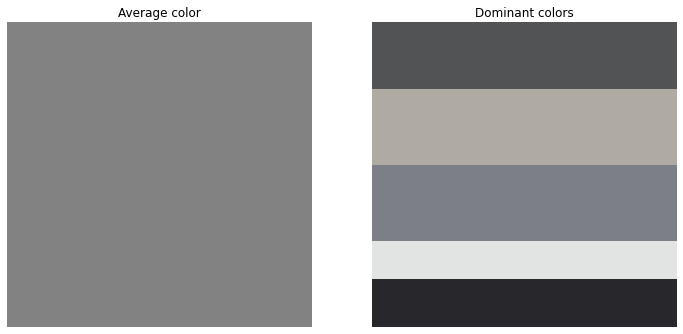

In [ ]:
# Examine Color Platte Summary  (pending)
img = X_train_object[0]
pixels = np.float32(img.reshape(-1, 3))
average = X_train_object[0].mean(axis=0).mean(axis=0)
import cv2
n_colors = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)
dominant = palette[np.argmax(counts)]

avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

indices = np.argsort(counts)[::-1]
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img.shape[0]*freqs)

dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
ax1.imshow(dom_patch)
ax1.set_title('Dominant colors')
ax1.axis('off')
plt.show(fig)

For a better visual of the overall data and the labels that are applied to it, we can see variations of the images and how they are classified below from the output.

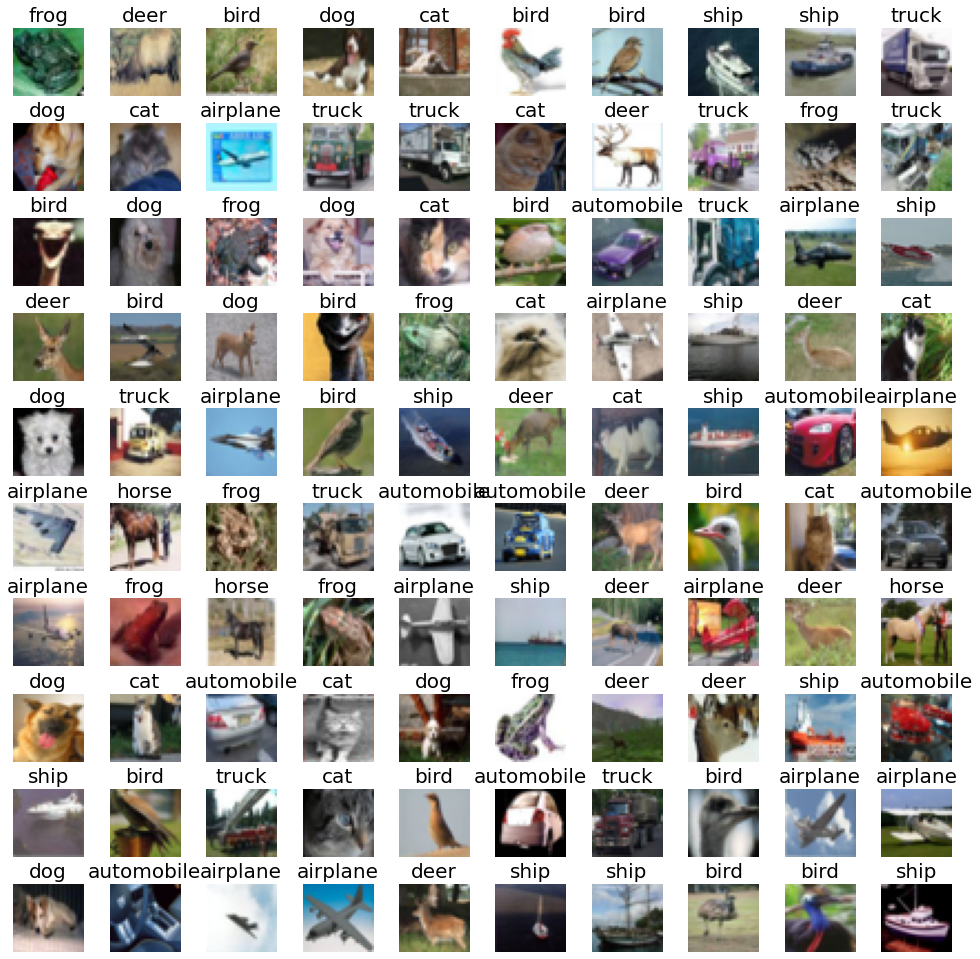

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 20)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## **Data Pre-processing**

- Defend any preprocessing and explain why you chose those particular method(s).
- How did you handle the color images?
- If you used dimension reduction methods, how/why did you optimize it the way you did (i.e., number of components used, include scree plot where possible)?

Before we can perform any analysis, we must reshape our data dimensions to be a 2D array for both datasets.

In [ ]:
# reshape dimensions to be 2d array for both the train and test sets
nsamples_train, nx, ny, nrgb = X_train.shape
X_train_2d = X_train.reshape((nsamples_train,nx*ny*nrgb))
nsamples_test, nx, ny, nrgb = X_test.shape
X_test_2d = X_test.reshape((nsamples_test,nx*ny*nrgb))

# check dimensions
print(X_train_2d.shape)
print(X_test_2d.shape)

(50000, 3072)
(10000, 3072)


We split a part of our training data to create our validation dataset.

In [ ]:
# split training data to validate model testing
X_train, X_valid, y_train, y_valid = train_test_split(X_train_2d, y_train_cl, test_size=0.2, stratify=y_train_cl, random_state=100)

# check dimensions
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(40000, 3072)
(10000, 3072)
(40000, 1)
(10000, 1)


Lastly, we perform normalization amongst each of the datasets (i.e., training, validation, and testing) to maintain a uniform range among the pixels of all the images.

In [ ]:
# perform normalization
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_valid_standard = scaler.transform(X_valid)
X_test_standard = scaler.transform(X_test_2d)

# check dimensions for feature matrices in all 3 datasets
print(X_train_standard.shape)
print(X_valid_standard.shape)
print(X_test_standard.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


As a result, our final feature variables for the training, validation, and test sets are as follows, respectively: `X_train_standard`, `X_valid_standard`, and `X_test_standard`, whereas the final target variables are: `y_train`, `y_valid`, and `y_test_cl`


## **Initializing Model**

- Choose a simple, unoptimized model from this course to build a classifier. This will serve as a baseline to measure further optimizations of more complex models.
- Explain why you chose this model and some of its advantages and disadvantages.
- Evaluate the performance of the initial model using the appropriate metrics discussed in this course, and explain why you chose these.

### **Logistic Regression**

Pros :
* It is used when the data is linearly separable.
* It is easy to implement, interpret and efficient to train.
* It gives the measure of how importance of a predictor both in positive or negative direction.

Cons :
* It can overfit in high dimensional datasets.
* Does not support non-linear relationship between the predictor and the outcome.

In [ ]:
# set random seed
seed(2023)
tf.random.set_seed(2023)

# fit model
lr = LogisticRegression().fit(X_train_standard, y_train.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
## Training set:
# computes predictions and probabilities
preds_lr_train = lr.predict(X_train_standard)
probs_lr_train = lr.predict_proba(X_train_standard)[:, 1]
print('\nTraining Data:')
# prints results for model metrics
print(classification_report(y_train, preds_lr_train))
print('ROC AUC Score: ', roc_auc_score(y_train, probs_lr_train).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_train, preds_lr_train)).round(2))

## Validation set:
# computes predictions and probabilities
preds_lr_valid = lr.predict(X_valid_standard)
probs_lr_valid = lr.predict_proba(X_valid_standard)[:, 1]
print('\nValidation Data:')
# prints results for model metrics
print(classification_report(y_valid, preds_lr_valid))
print('ROC AUC Score: ', roc_auc_score(y_valid, probs_lr_valid).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_valid, preds_lr_valid)).round(2))

## Test set:
# computes predictions and probabilities
preds_lr_test = lr.predict(X_test_standard)
probs_lr_test = lr.predict_proba(X_test_standard)[:, 1]
print('\nTesting Data:')
# prints results for model metrics
print(classification_report(y_test_cl, preds_lr_test))
print('ROC AUC Score: ', roc_auc_score(y_test_cl, probs_lr_test).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_test_cl, preds_lr_test)).round(2))


Training Data:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     24000
           1       0.81      0.75      0.78     16000

    accuracy                           0.83     40000
   macro avg       0.83      0.82      0.82     40000
weighted avg       0.83      0.83      0.83     40000

ROC AUC Score:  0.9
RMSE:  0.41

Validation Data:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      6000
           1       0.80      0.74      0.77      4000

    accuracy                           0.82     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.82      0.82     10000

ROC AUC Score:  0.88
RMSE:  0.42

Testing Data:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      6000
           1       0.79      0.73      0.76      4000

    accuracy                           0.82     10000
   macro avg  

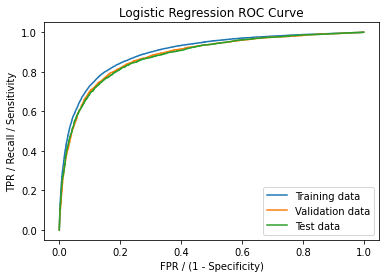

In [ ]:
# Plot:
fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, probs_lr_train)
fpr_lr_valid, tpr_lr_valid, _ = roc_curve(y_valid, probs_lr_valid)
fpr_lr_test, tpr_lr_test, _ = roc_curve(y_test_cl, probs_lr_test)

plt.plot(fpr_lr_train, tpr_lr_train, label = "Training data")
plt.plot(fpr_lr_valid, tpr_lr_valid, label = "Validation data")
plt.plot(fpr_lr_test, tpr_lr_test, label = "Test data")

plt.title('Logistic Regression ROC Curve')
plt.xlabel('FPR / (1 - Specificity)')
plt.ylabel('TPR / Recall / Sensitivity')
plt.legend(loc="lower right")
plt.show()

## **Model Optimization**

- Choose a model (or models) to further optimize, and improve on the results from your initial model.
- You can choose to use:
    - Random Forests and Gradient Boosted Decision Trees, or
    - Neural Networks
- Justify why the models were selected. What are the advantages and disadvantages for this model compared to others?
- Optimize the chosen models to get better performance metrics.
- Discuss the methods used to optimize your model. How did you choose the tuning parameters?

### **Neural Networks**

Goal: Get the best accuracy on the test set. Constraints: Don't overfit to the test set.

Parameter options:
- Increase the number of hidden layers
- Increase the number of neurons per layer
- Change the number of epochs and/or batch_size
- Add L1 or L2 regularization to the layers
- Use dropout
- Use early stopping
- Change the activation function (tanh, relu, sigmoid)


In [ ]:
# set random seed
seed(2023)
tf.random.set_seed(2023)

# design
model_nn = Sequential()
model_nn.add(Dense(29, activation='relu', input_shape=(X_train_standard.shape[1], )))
model_nn.add(Dropout(rate=.36))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.summary()
model_nn.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit model
history = model_nn.fit(X_train_standard, y_train, epochs=65, batch_size=200,
                    validation_data=(X_valid_standard, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                89117     
                                                                 
 dropout (Dropout)           (None, 29)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 30        
                                                                 
Total params: 89,147
Trainable params: 89,147
Non-trainable params: 0
_________________________________________________________________
Epoch 1/65
200/200 [==============================] - 2s 7ms/step - loss: 0.5049 - accuracy: 0.7728 - val_loss: 0.3998 - val_accuracy: 0.8304
Epoch 2/65
200/200 [==============================] - 1s 6ms/step - loss: 0.4408 - accuracy: 0.8080 - val_loss: 0.3818 - val_accuracy: 0.8410
Epoch 3/65
200/200 [============

In [ ]:
# Loss (cross-entropy) and accuracy using valid set
print(model_nn.metrics_names)
#model_nn.evaluate(X_valid_standard, y_valid, verbose=0)
model_nn.evaluate(X_test_standard, y_test_cl, verbose=0)

['loss', 'accuracy']


[0.29816722869873047, 0.8776999711990356]

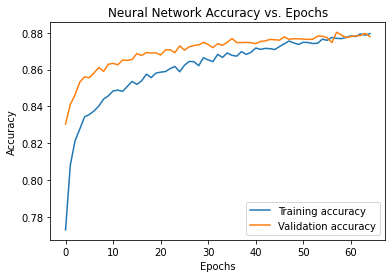

In [ ]:
# checks accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Neural Network Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

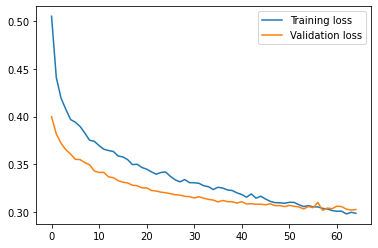

In [ ]:
# checks loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
## Training set:
# computes predictions and probabilities for train set from neural network model
probs_nn_train = model_nn.predict(X_train_standard)
preds_nn_train = np.where(probs_nn_train > 0.5, 1, 0 )
print('\nTraining Data:')
print(classification_report(y_train, preds_nn_train))
print('ROC AUC Score: ', roc_auc_score(y_train, probs_nn_train).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_train, probs_nn_train)).round(2))

## Validation set:
# computes predictions and probabilities for train set from neural network model
probs_nn_valid = model_nn.predict(X_valid_standard)
preds_nn_valid = np.where(probs_nn_valid > 0.5, 1, 0 )
print('\nValidation Data:')
print(classification_report(y_valid, preds_nn_valid))
print('ROC AUC Score: ', roc_auc_score(y_valid, probs_nn_valid).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_valid, probs_nn_valid)).round(2))

## Test set:
# computes predictions and probabilities for train set from neural network model
probs_nn_test = model_nn.predict(X_test_standard)
preds_nn_test = np.where(probs_nn_test > 0.5, 1, 0 )
print('\nTest Data:')
print(classification_report(y_test_cl, preds_nn_test))
print('ROC AUC Score: ', roc_auc_score(y_test_cl, probs_nn_test).round(2))
print('RMSE: ', np.sqrt(mean_squared_error(y_test_cl, probs_nn_test)).round(2))


1250/1250 [==============================] - 2s 2ms/step

Training Data:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     24000
           1       0.90      0.87      0.88     16000

    accuracy                           0.91     40000
   macro avg       0.91      0.90      0.91     40000
weighted avg       0.91      0.91      0.91     40000

ROC AUC Score:  0.96
RMSE:  0.26
313/313 [==============================] - 1s 2ms/step

Validation Data:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6000
           1       0.86      0.83      0.85      4000

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000

ROC AUC Score:  0.94
RMSE:  0.3
313/313 [==============================] - 0s 2ms/step

Test Data:
              precision    recall  f1-score   support

           0 

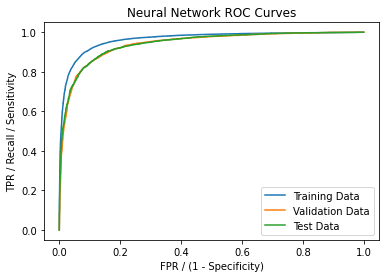

In [ ]:
# Plotting ROC Curves of Each Set
fpr_nn_test, tpr_nn_test, _lr_test = roc_curve(y_test_cl, probs_nn_test)
fpr_nn_train, tpr_nn_train, _lr_train = roc_curve(y_train, probs_nn_train)
fpr_nn_valid, tpr_nn_valid, _lr_valid = roc_curve(y_valid, probs_nn_valid)

plt.plot(fpr_nn_train, tpr_nn_train, label = "Training Data")
plt.plot(fpr_nn_valid, tpr_nn_valid, label = "Validation Data")
plt.plot(fpr_nn_test, tpr_nn_test, label = "Test Data")
plt.title('Neural Network ROC Curves')
plt.xlabel('FPR / (1 - Specificity)')
plt.ylabel('TPR / Recall / Sensitivity')
plt.legend(loc="lower right")
plt.show()

## **Compare Model Performances**
Include any figures to compare the performance of the models, or to summarize the results.

In [ ]:
# table
print(tabulate([['Neural Network',
                 accuracy_score(y_test_cl, preds_nn_test).round(3),
                 roc_auc_score(y_test_cl, probs_nn_test).round(3),
                 np.sqrt(mean_squared_error(y_test_cl, probs_nn_test)).round(3),
                 precision_score(y_test_cl, preds_nn_test).round(3),
                 recall_score(y_test_cl, preds_nn_test).round(3)
                 ],
                ['Logistic Regression',
                 accuracy_score(y_test_cl, preds_lr_test).round(3),
                 roc_auc_score(y_test_cl, preds_lr_test).round(3),
                 np.sqrt(mean_squared_error(y_test_cl, probs_lr_test)).round(3),
                 precision_score(y_test_cl, preds_lr_test).round(3),
                 recall_score(y_test_cl, preds_lr_test).round(3)
                 ]],
               headers=['Model', 'Accuracy', 'ROC AUC Score', 'RMSE', 'Precision', 'Recall']))


Model                  Accuracy    ROC AUC Score    RMSE    Precision    Recall
-------------------  ----------  ---------------  ------  -----------  --------
Neural Network            0.878            0.942   0.299        0.859     0.831
Logistic Regression       0.816            0.803   0.365        0.793     0.733


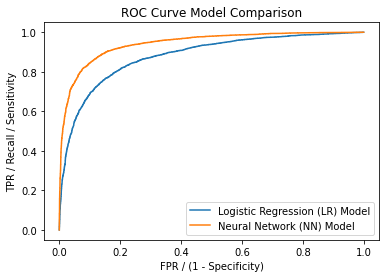

In [ ]:
# Plot
fpr_lr, tpr_lr, _lr = roc_curve(y_test_cl, probs_lr_test)
fpr_nn, tpr_nn, _nn = roc_curve(y_test_cl, probs_nn_test)


plt.plot(fpr_lr, tpr_lr, label = "Logistic Regression (LR) Model")
plt.plot(fpr_nn, tpr_nn, label = "Neural Network (NN) Model")

plt.title("ROC Curve Model Comparison")
plt.legend(loc="lower right")
plt.xlabel('FPR / (1 - Specificity)')
plt.ylabel('TPR / Recall / Sensitivity')
plt.show()

## **Misclassification Analysis**

We were curious on how the model’s misclassification rate were affecting each class image.



In [ ]:
from collections import Counter
# filters the image classs that were misclassifed
lr_misclassified = preds_lr_test != y_test_cl.flatten()
# Accounts for the number of misclassifications made by each image class
print('LR model:', Counter(y_test[lr_misclassified].flatten()).most_common())
# filters the image class that were misclassifed
nn_misclassified = preds_nn_test != y_test_cl
# Accounts for the number of misclassifications made by each image class
print('NN model:', Counter(y_test[nn_misclassified]).most_common())

LR model: [(0, 326), (1, 292), (9, 248), (8, 202), (7, 177), (2, 171), (3, 136), (5, 119), (4, 99), (6, 65)]
NN model: [(0, 224), (9, 166), (1, 143), (8, 142), (2, 139), (7, 107), (3, 94), (4, 91), (5, 66), (6, 51)]


As a result, both models misclassified the image class Airplane (i.e., 0) the most, while misclassifying the image class Frog (i.e., 6) the least. Overall, objects were misclassified much more frequently than animals.